In [1]:
from script.data_loader import get_patient_loader
import zennit as zen
import pandas as pd
import torch
import os
import copy
import torch.nn as nn

from script.model import get_res18_ciga, get_res50_dropout, get_remote_models_and_path_mki67
from script.relevance import plot_relevance,get_attributions_from_loader
import matplotlib.pyplot as plt
from script.plot_and_print import plot_data_mapped, print_metrics, plot_data_scatter
from script.process_csv import generate_results, merge_data
from script.data_loader import get_data_loaders

#from torchvision.transforms import v2
import torchvision


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

path = "../models/res18/res18_not_iced_e29.pt"
res18_no_ice = get_res18_ciga(path).to(device)
path = "../models/res18/RUBCNL_HLR_Res18_optim_ice/15072024_ep_29_lr_0.0005resnet.pt"
res18_ice    = get_res18_ciga(path).to(device)
res18_ice.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
path = "../models/res18/res18_iced_e29.pt"
res18    = get_res18_ciga(path).to(device)
path = "../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt"
res50_drop = get_res50_dropout(path)

data_dir = "../Training_Data/"
patient = "/p020"
base_path = data_dir+patient+"/Preprocessed_STDataset/"
merge = pd.read_csv(base_path + "merge.csv")
loader = get_patient_loader(data_dir, patient)

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [45]:
# drop dropout layers so that restructuring works as that function requires lin relu lin as the upper layers
res50_drop_copy = copy.deepcopy(res50_drop)
print(res50_drop_copy.gene1)
idx = [0,2,3]
res50_drop_copy.gene1 = nn.Sequential(*[res50_drop_copy.gene1[i] for i in idx])
print(res50_drop_copy.gene1)


In [61]:
can_res = zen.torchvision.ResNetCanonizer()
composite = zen.composites.EpsilonPlusFlat(canonizers=[can_res])
# out, out_orig, grad, target, x, y, name
res50_drop.eval()
out_target = get_attributions_from_loader(res50_drop_copy.to(device), loader, device, data_dir, patient, composite, -1, 20)

In [48]:
from script.relevance import get_img_target_name

In [62]:
print(len(out_target))

In [49]:
img, target, name = get_img_target_name(loader, device, 0)
print(img.shape)

In [3]:
models = get_remote_models_and_path_mki67()

<All keys matched successfully>
<All keys matched successfully>


In [14]:
def process_and_plot_patient(model, device, data_dir, patient, gene = "RUBCNL", results_filename = "results.csv"):
    generate_results(model, device, data_dir, patient, gene, results_filename)
    merge_data(data_dir, patient, results_filename)
    plot_data_mapped(data_dir, patient, "labels")
    plot_data_mapped(data_dir, patient, "output")
    plot_data_mapped(data_dir, patient, "diff")
    plot_data_scatter(data_dir, patient, gene)
    print_metrics(data_dir, patient, "mean")
    print_metrics(data_dir, patient, "std")
    print_metrics(data_dir, patient, "pearson")
    
    print("----------------------------------------")

generating results...


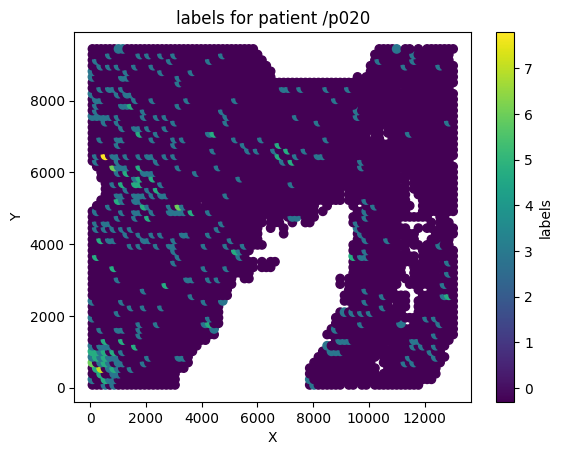

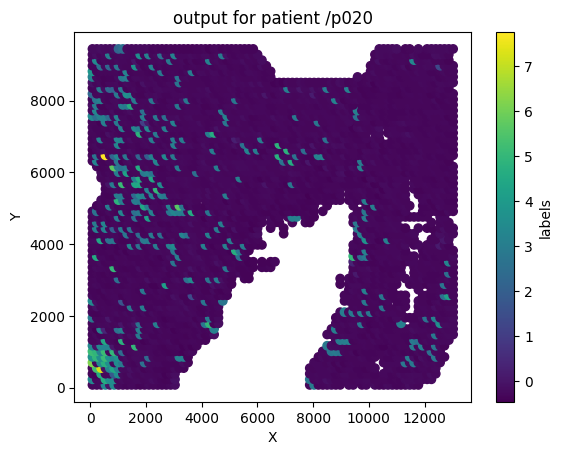

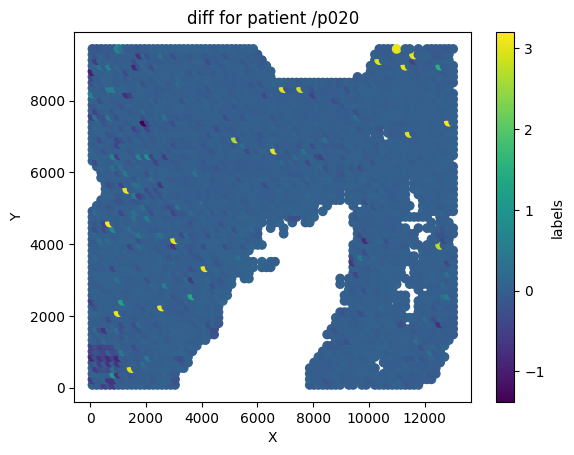

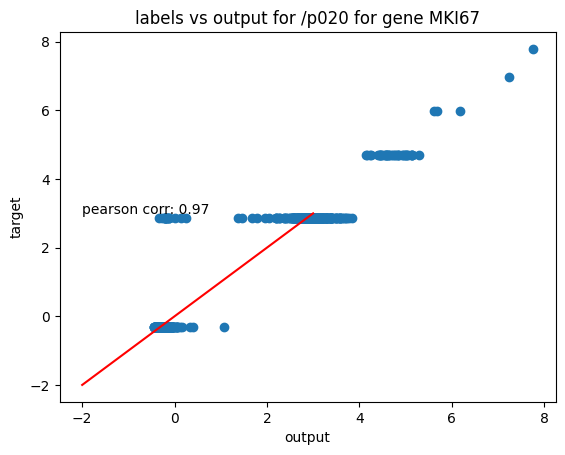

mean diff:  0.0016 , mean out:  0.0015 , mean labels:  -0.0001
std diff:  0.0042 , std out:  1.0042 , std labels:  1.0001
----------------------------------------
generating results...


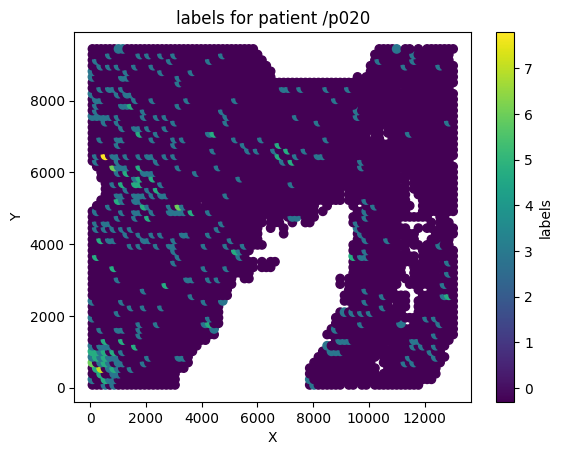

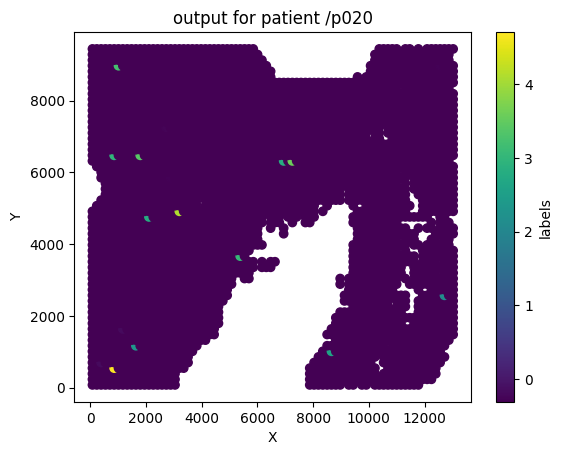

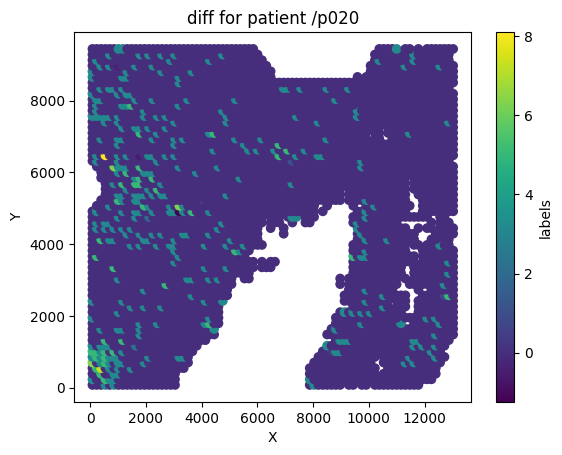

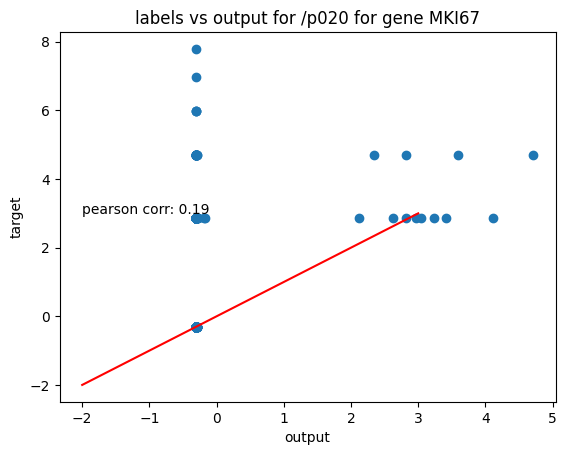

mean diff:  0.2940 , mean out:  -0.2941 , mean labels:  -0.0001
std diff:  0.8078 , std out:  0.1922 , std labels:  1.0001
----------------------------------------


In [16]:
process_and_plot_patient(models[0][0].to(device), device, data_dir, patient, "MKI67", results_filename = "MKI67_slim_model_results.csv")
process_and_plot_patient(models[1][0].to(device), device, data_dir, patient, "MKI67", results_filename = "MKI67_slim_model_results.csv")


In [54]:

composite = zen.composites.EpsilonPlusFlat(canonizers=[zen.torchvision.ResNetCanonizer()])

images = []
coords = []
for i in range(len(out_target)):
    with open("xai_log.txt", "a") as f:
        out, out_orig, out_orig_restructured, grad, target, x, y, name = out_target[i]
        s = "out: " + str(out.item()) + ", out_orig: " + str(out_orig.item()) + ", out_orig_restructured: " + str(out_orig_restructured.item()) + ", target: " + str(target.item()) + ", filename: " + os.path.basename(name.replace("//", "/")) + "\n"
        f.write(s)
        import cv2
        img = cv2.imread(name)
        
        #img = plt.imread(name)
        coords.append([x-112,x+112,y-112,y+112])
        
        img_tns = torch.tensor(img)
        img_tns_rs=img_tns.permute(2, 1, 0)
        transform = v2.Resize((50, 50), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
        
        #print(transform(channel_0).shape)
        img_out = transform(img_tns_rs)
        assert(img_out.shape == (3,50,50))
        torch.save(img_out, "../xai/relevance_scaled_tiles" + patient + "/" + os.path.basename(name)[:-4] + "pt")

In [69]:
composite = zen.composites.EpsilonPlusFlat(canonizers=[zen.torchvision.ResNetCanonizer()])

images = []
coords = []
for i in range(len(out_target)):
    out, out_orig, out_orig_restructured, grad, target, x, y, name = out_target[i]
    s = "out: " + str(out.item()) + ", out_orig: " + str(out_orig.item()) + ", out_orig_restructured: " + str(out_orig_restructured.item()) + ", target: " + str(target.item()) + ", filename: " + os.path.basename(name.replace("//", "/")) + "\n"
    print(s)
    plot_relevance(grad)
    print(name)
    from PIL import Image
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

In [4]:
print(len(loader))

In [98]:

import copy
composite = zen.composites.EpsilonPlusFlat(canonizers=[zen.torchvision.ResNetCanonizer()])

images = []
coords = []
print(patient)
for i in range(len(loader)):
    with open("xai_log.txt", "a") as f:
        out_target = get_attributions_from_loader(res50_drop_copy, loader, device, data_dir, patient, composite, i, -1)

        out, out_orig, out_orig_restructured, grad, target, x, y, name = out_target[0]
        print(y)
        break
        s = "out: " + str(out.item()) + ", out_orig: " + str(out_orig.item()) + ", out_orig_restructured: " + str(out_orig_restructured.item()) + ", target: " + str(target.item()) + ", filename: " + os.path.basename(name.replace("//", "/")) + "\n"
        f.write(s)
        #plot_relevance(grad)
        #print(grad.shape)
        import cv2
        img = cv2.imread(name)
        
        #img = plt.imread(name)
        coords.append([x-112,x+112,y-112,y+112])
        
        img_tns = torch.tensor(img)
        img_tns_rs=img_tns.permute(2, 1, 0)
        transform = v2.Resize((50, 50), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
        
        #print(transform(channel_0).shape)
        img_out = transform(img_tns_rs)
        assert(img_out.shape == (3,50,50))
        torch.save(img_out, "../xai/relevance_scaled_tiles" + patient + "/" + os.path.basename(name)[:-4] + "pt")


In [8]:
len(coords)
coords_fixed = []
for _, (a,b,c,d) in enumerate(coords):
    coords_fixed.append((a+87, b-87, c+87, d-87))
    

In [9]:
print(len(coords_fixed))

In [12]:
imgs = []
for i in range(int(len(loader)/2)):
    img, target, name = loader[i]
    out = torch.load("../xai/relevance_scaled_tiles" + patient + "/" + os.path.basename(name)[:-4] + "pt")
    imgs.append(out)

In [80]:
coords_half = coords[:int(len(loader)/2)]

In [81]:
#print(len(imgs))
print(len(coords_half))


In [90]:
coords_half_copy = copy.deepcopy(coords_half)
for i, c in enumerate(coords_half_copy):
    coords_half_copy[i] = [tuple(x.to_list()) for x in c]

In [91]:
print(type(coords_half[0][0]))
print(coords_half[0])
print(type(coords[0][0]))
print(coords[0])
print(type(coords_half_copy[0][0]))
print(coords_half_copy[0])


In [29]:
fig, ax = plt.subplots(1,1)
for extent, img in zip(coords_half, imgs):
    img = img.permute(2,1,0)
    print(extent)
    print(type(extent[0]))
    extend = [extent]
    print(type(extend))
    ax.imshow(img, extent=extent)
    break

In [75]:


img_tns = torch.tensor(img)
print(img_tns.shape)
img_tns_rs=img_tns.permute(2, 1, 0)
print(img_tns_rs.shape)
#channel_0 = img_tns_rs[0].unsqueeze(0)
#print(channel_0.unsqueeze(0).shape)

#t = torchvision.transforms.Grayscale()
#tns_grey = t(img_tns_rs)
#print(img_tns_rs.shape)
transform = v2.Resize((50, 50), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)

#print(transform(channel_0).shape)
img_out = transform(img_tns_rs)
print(img_out.shape)
plt.imshow(img_out.permute(2,1,0))

In [72]:

from torchvision import transforms
from PIL import Image

# Load the image
image = Image.open('path_to_your_image.jpg')

# Define the transform to resize the image
resize_transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Resize to 50x50
])

# Apply the transform to the image
resized_image = resize_transform(image)

In [61]:
plt.imshow(tns_grey.reshape(-1,156,1))

In [41]:
plt.imshow(img_out)
